In [1]:
%matplotlib inline
#
from lrgsglib.shared import *
from lrgsglib.config.utils import log_binning
from lrgsglib.core import Lattice2D, Lattice3D, SignedRW, move_to_rootf
#
move_to_rootf()
plt.style.use("ipynb/nb_plotsheet.mplstyle")

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


In [2]:
sys.path.append('src/lrgsglib/Ccore/stocproc/')


In [3]:
import random_walk


ImportError: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib/src/lrgsglib/Ccore/stocproc/random_walk.cpython-312-x86_64-linux-gnu.so: invalid ELF header

In [2]:
def process_signed_random_walk(data):
    """
    Processes a list of node-sign pairs to determine the distribution of unique nodes
    within clusters of consecutive identical signs.

    Args:
    data (list of tuples): List where each tuple contains a node (as a tuple) and a sign (+1 or -1).

    Returns:
    dict: A dictionary where keys are signs and values are lists of counts of unique nodes per cluster.
    """
    cluster_sizes = defaultdict(list)
    if not data:
        return dict(cluster_sizes)  # Return an empty dictionary if data is empty

    current_cluster = set()
    current_sign = data[0][1]

    for node, sign in data:
        if sign != current_sign:
            # Store size of the current cluster and reset
            cluster_sizes[current_sign].append(len(current_cluster))
            current_cluster = set()
            current_sign = sign
        current_cluster.add(node)

    # Add the last cluster
    cluster_sizes[current_sign].append(len(current_cluster))

    return dict(cluster_sizes)

In [3]:
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def max_distance(states):
    initial_state = states[0][0]
    max_dist = 0
    
    for state in states:
        current_state = state[0]
        distance = euclidean_distance(initial_state, current_state)
        if distance > max_dist:
            max_dist = distance
    
    return max_dist

In [5]:
l = Lattice2D(10, pflip=0.5, geo='triangular')
l.flip_random_fract_edges()
srw = SignedRW(l, simTime=100,  stopSim=True,
        initMode="random", 
        runMode="py",
        storeMode="sequential",
        storeFreq=1)

In [6]:
side = 64
navg = 500
simtime = 10000
pflipList = [0.1, 0.2]

In [7]:
maDict = {}
for pflip in pflipList:
    maxD = []
    maxL = []
    maDict[pflip] = {}
    for i in range(navg):
        l = Lattice2D(side, pflip=pflip, geo='triangular')
        l.flip_random_fract_edges()
        srw = SignedRW(l, simTime=simtime,  stopSim=True,
                initMode="random", 
                runMode="py",
                storeMode="sequential",
                storeFreq=1)
        srw.run()
        if srw.StopFlag:
            maxD.append(max_distance(srw.s_tList))
            maxL.append(len(srw.s_tList))
    maDict[pflip]['maxD'] = np.array(maxD)
    maDict[pflip]['maxL'] = np.array(maxL)
    # arr = np.array(maxD)
    # arr = arr[arr != 0]
    # maDict[pflip] = {}
    # ['mean'] = np.mean(arr)
    # maDict[pflip]['max'] = max(arr)
    # # fit = powerlaw.Fit(arr)
    # # fit.plot_ccdf(color='b', linewidth=2)
    # edges, hist = powerlaw.pdf(arr)
    # bin_centers = (edges[1:]+edges[:-1])/2.0
    # plt.loglog(bin_centers, hist, label=f"pflip={pflip:.3g}")
# plt.legend()

NameError: name 'max_distance' is not defined

In [8]:
for pflip in pflipList:
    arr = maDict[pflip]['maxD']
    arr = arr[arr != 0]
    # arr_sorted = np.sort(arr)
    # # Calculate the CCDF
    # ccdf = np.arange(1, len(arr_sorted) + 1)[::-1] / len(arr_sorted)
    # # Plot the CCDF on a log-log scale
    # plt.loglog(arr_sorted, ccdf, marker='o', linestyle='none')
    edges, hist = powerlaw.ccdf(arr)
    bin_centers = (edges[1:]+edges[:-1])/2.0
    plt.plot(bin_centers, hist, label=f"pflip={pflip:.3g}")
# plt.axvline(63, c='k', ls='--')
# plt.axhline(0.5, c='k', ls='--')
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()

KeyError: 'maxD'

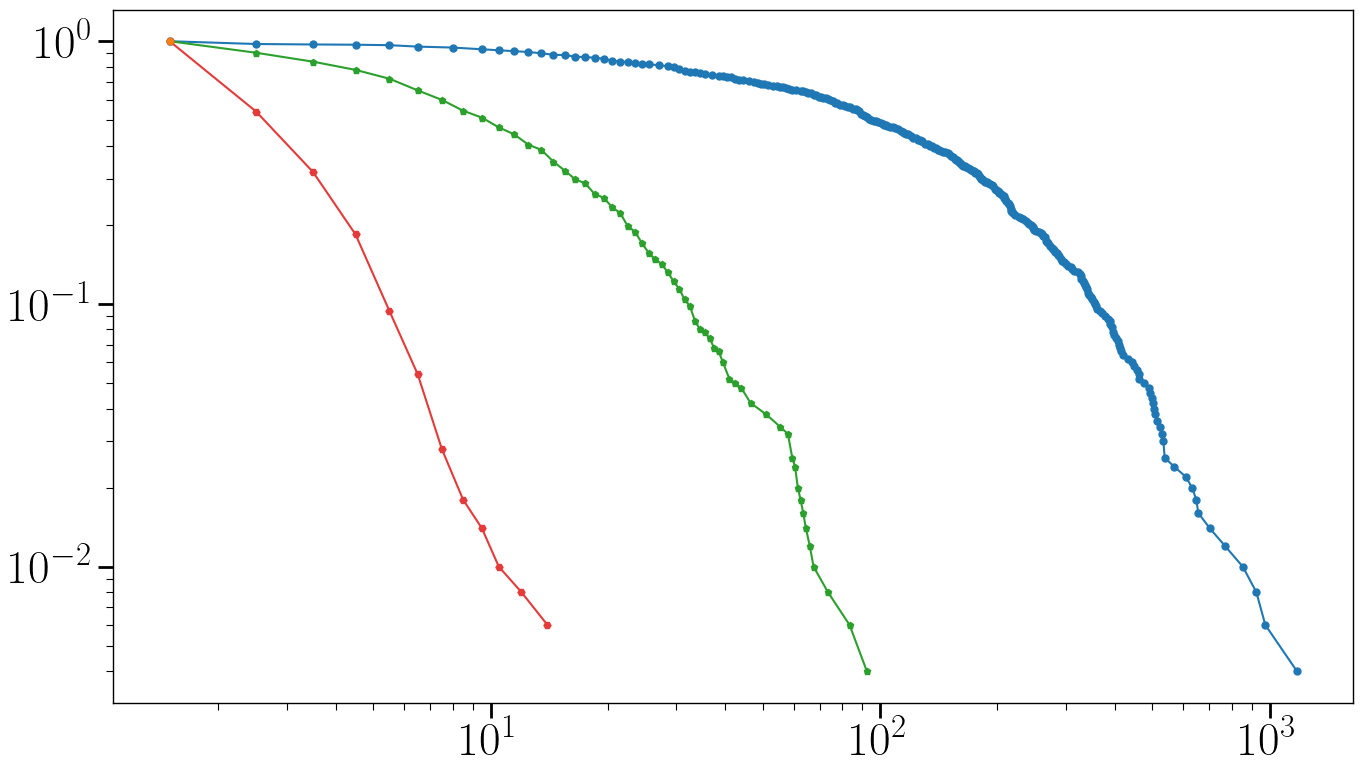

In [37]:
for pflip in pflipList:
    arr = maDict[pflip]['maxL']
    edges, hist = powerlaw.ccdf(arr)
    # arr_sorted = np.sort(arr)

    # # Calculate the CCDF
    # ccdf = np.arange(1, len(arr_sorted) + 1)[::-1] / len(arr_sorted)

    # # Plot the CCDF on a log-log scale
    # plt.loglog(arr_sorted, ccdf, marker='o', linestyle='none')
    bin_centers = (edges[1:]+edges[:-1])/2.0
    plt.loglog(bin_centers, hist[:-1])

In [6]:
np.mean(arr)

27.40508009373004

In [ ]:
l = Lattice2D(side, pflip=pflipList[0], with_positions=True)
l.flip_random_fract_edges()

In [ ]:
nx.draw(l.G, pos=l.get_node_pos(), edge_color=l.get_edge_color())

In [ ]:
side = 12
navg = 100
simtime = 100
pflipList = [0.01, 0.04, 0.06, 0.08, 0.103, 0.25, 0.5]
#
data = {}
#
for pflip in pflipList:
    data[pflip] = []
    for na in range(navg):
        l = Lattice2D(side, pflip=pflip)
        l.flip_random_fract_edges()
        srw = SignedRW(l, simTime=simtime,, stopSim=True, 
                initMode="random", 
                runMode="py",
                storeMode="sequential",
                storeFreq=1)
        srw.run()
        data[pflip].extend(srw.s_tList)
    cluster_sizes = process_signed_random_walk(data[pflip])
    edges, hist = powerlaw.pdf(cluster_sizes[-1], xmin=1)
    bin_centers = (edges[1:]+edges[:-1])/2.0
    plt.loglog(bin_centers, hist)
    edges, hist = powerlaw.pdf(cluster_sizes[1], xmin=1)
    bin_centers = (edges[1:]+edges[:-1])/2.0
    plt.loglog(bin_centers, hist)
    plt.xlabel(r'$\tau$')
    plt.ylabel(r'$P(\tau)$')
    plt.title(fr'$p={pflip:.3g}$')
    plt.show()

In [ ]:
cluster_sizes

In [ ]:
fig, ax = plt.subplots()
l_ini = Lattice2D(32)
mmax = l_ini.Ne//10
for i in range(1, mmax, mmax//8):
    print("Current value of p:", i/l_ini.Ne)  # Debugging statement to check p
    l = Lattice2D(32, pflip=i/l_ini.Ne)
    l.flip_random_fract_edges()
    srw = SignedRW(l, simTime=2000, 
               initMode="random", 
               runMode="py",
               storeMode="sequential",
               storeFreq=1)
    srw.run()
    a = np.array(srw.s_tList, dtype=object)[:, 1].astype(int)
    changes = np.where(np.diff(a) != 0)[0] + 1
    sequence_lengths = np.diff(np.hstack(([0], changes, [len(a)])))
    # print(sequence_lengths)
    # b, h, w = log_binning(sequence_lengths, binnum=15)
    # ax.plot(b, h/w)
    edges, hist = powerlaw.pdf(sequence_lengths, xmin=1)
    bin_centers = (edges[1:]+edges[:-1])/2.0
    ax.loglog(bin_centers, hist)
plt.show()

In [ ]:
fig, ax = plt.subplots()
for p in [0.01, 0.05, 0.08, 0.1, 0.2, 0.5]:
    print("Current value of p:", p)  # Debugging statement to check p
    l = Lattice2D(128, pflip=p)
    l.flip_random_fract_edges()
    srw = SignedRW(l, simTime=2000, 
               initMode="random", 
               runMode="py",
               storeMode="sequential",
               storeFreq=1)
    srw.run()
    a = np.array(srw.s_tList, dtype=object)[:, 1].astype(int)
    changes = np.where(np.diff(a) != 0)[0] + 1
    sequence_lengths = np.diff(np.hstack(([0], changes, [len(a)])))
    print(sequence_lengths)
    # b, h, w = log_binning(sequence_lengths, binnum=15)
    # ax.plot(b, h/w)
    edges, hist = powerlaw.pdf(sequence_lengths)
    bin_centers = (edges[1:]+edges[:-1])/2.0
    ax.loglog(bin_centers, hist)
plt.show()

In [ ]:
b, h, w = log_binning(sequence_lengths, binnum=15)
plt.plot(b, h/w)
plt.yscale("log")
plt.xscale("log")

In [ ]:
a.alpha